In [1]:
import pandas as pd
import panel as pn
import numpy as np
from sqlalchemy import create_engine
from datetime import date, timedelta
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set

pn.extension('tabulator')

engine = create_engine("mysql+pymysql://root:@localhost:3306/stock")
const = engine.connect()
engine = create_engine("sqlite:///c:\\ruby\\portmy\\db\\development.sqlite3")
conmy = engine.connect()
format_dict = {
               'fm_price':'{:.2f}','to_price':'{:.2f}','price':'{:.2f}',    
               'max_price':'{:.2f}','min_price':'{:.2f}','maxp':'{:.2f}','minp':'{:.2f}',
               'opnp':'{:.2f}','target':'{:.2f}','max':'{:.2f}','max52':'{:.2f}',
               'css_price':'{:.2f}','amount':'{:,.2f}','unit_cost':'{:.2f}',
               'cost_amt':'{:,.2f}','dividend_amount':'{:,.2f}','base':'{:,.2f}',
               'dividend':'{:.2f}','div_amt':'{:,.2f}',
               'cost_pct':'{:.2f}%','mkt_pct':'{:.2f}%','pft_pct':'{:.2f}%','pct':'{:.2f}%', 
               'buy_target':'{:.2f}','sell_target':'{:.2f}',
               'volume':'{:,.2f}','beta':'{:.2f}','cost':'{:,.2f}','profit':'{:,.2f}',
               'qty':'{:,}','available_qty':'{:,}','shares':'{:,}','volbuy':'{:,}','div_rank':'{:,}','amt_rank':'{:,}'}
pd.set_option("display.max_rows", None)

data_path = "../data/"
csv_path = "\\Users\\User\\iCloudDrive\\"
box_path = "\\Users\\User\\Dropbox\\"

today = date.today()
today

datetime.date(2022, 1, 8)

### Set today = last closed business day

In [2]:
today = today - timedelta(days=1)
today

datetime.date(2022, 1, 7)

### Restart and Run All Cells

In [3]:
sql = '''
UPDATE buy B
SET dividend =
(SELECT DIVIDEND FROM dividend D
WHERE B.name = D.name)'''
rp = const.execute(sql)
rp.rowcount

34

In [4]:
colt = 'name shares unit_cost cost price amount mkt_pct div_rnk amt_rnk div_amt'.split()

### Process portfolio (table buy in mysql stock)

In [5]:
sql = '''
SELECT name, volbuy AS shares, price AS unit_cost, volbuy * price AS cost, dividend,
volbuy * dividend AS div_amt, FORMAT((volbuy * dividend)/(volbuy * price) * 100,2) AS cost_pct, period
FROM buy
WHERE active = 1'''
df_buy = pd.read_sql(sql, const)
df_buy['shares'] = df_buy.shares.astype(int)
df_buy['cost_pct'] = df_buy.cost_pct.astype(float)
df_buy.sort_values(['name'],ascending=[True]).head().style.format(format_dict)

,name,shares,unit_cost,cost,dividend,div_amt,cost_pct,period
10,BCH,"15,000",21.30,"319,500.00",0.33,"4,950.00",1.55%,3
29,BGRIM,"9,000",40.00,"360,000.00",0.45,"4,050.00",1.13%,4
19,CKP,"30,000",5.00,"150,000.00",0.04,"1,050.00",0.70%,3
6,DIF,"60,000",14.70,"882,000.00",1.04,"62,640.00",7.10%,2
12,DOHOME,"12,000",24.30,"291,600.00",0.10,"1,200.00",0.41%,3


In [6]:
file_name = 'hi-dividend.csv'
data_file = data_path + file_name
output_file = csv_path + file_name
box_file = box_path + file_name

df_buy.sort_values(['cost_pct'],ascending=[False]).to_csv(output_file)
df_buy.sort_values(['cost_pct'],ascending=[False]).to_csv(data_file)
df_buy.sort_values(['cost_pct'],ascending=[False]).to_csv(box_file)

### Start of Period Calculation

In [7]:
sql = '''
SELECT B.name, volbuy AS shares, B.price AS unit_cost, volbuy * B.price AS cost, 
dividend, volbuy * dividend AS div_amt, 
FORMAT((volbuy * dividend)/(volbuy * B.price) * 100,1) AS cost_pct, 
P.price, volbuy * P.price AS amount, 
FORMAT((volbuy * dividend)/(volbuy * P.price) * 100,1) AS mkt_pct,
(P.price - B.price) * volbuy AS profit, 
FORMAT(((P.price - B.price) * volbuy) / (volbuy * B.price) * 100,1) AS pft_pct, period
FROM buy B JOIN price P
ON B.name = P.name
WHERE P.date = "%s"
AND active = 1'''
sql = sql % today 
print(sql)

df_buy_price = pd.read_sql(sql, const)
df_buy_price['shares'] = df_buy_price.shares.astype(int)
df_buy_price['cost_pct'] = df_buy_price.cost_pct.astype(float)
df_buy_price['mkt_pct'] = df_buy_price.mkt_pct.astype(float)
df_buy_price['pft_pct'] = df_buy_price.pft_pct.astype(float)
df_buy_price.sort_values(['pft_pct'],ascending=[False]).head().style.format(format_dict)


SELECT B.name, volbuy AS shares, B.price AS unit_cost, volbuy * B.price AS cost, 
dividend, volbuy * dividend AS div_amt, 
FORMAT((volbuy * dividend)/(volbuy * B.price) * 100,1) AS cost_pct, 
P.price, volbuy * P.price AS amount, 
FORMAT((volbuy * dividend)/(volbuy * P.price) * 100,1) AS mkt_pct,
(P.price - B.price) * volbuy AS profit, 
FORMAT(((P.price - B.price) * volbuy) / (volbuy * B.price) * 100,1) AS pft_pct, period
FROM buy B JOIN price P
ON B.name = P.name
WHERE P.date = "2022-01-07"
AND active = 1


,name,shares,unit_cost,cost,dividend,div_amt,cost_pct,price,amount,mkt_pct,profit,pft_pct,period
27,IMH,"4,500",11.00,"49,500.00",nan,nan,nan%,16.40,"73,800.00",nan%,"24,300.00",49.10%,3
31,RCL,"4,500",43.00,"193,500.00",3.50,"15,750.00",8.10%,52.75,"237,375.00",6.60%,"43,875.00",22.70%,3
18,SIS,"1,500",37.50,"56,250.00",1.00,"1,500.00",2.70%,44.50,"66,750.00",2.20%,"10,500.00",18.70%,3
2,SAT,"7,500",21.10,"158,250.00",0.88,"6,600.00",4.20%,23.40,"175,500.00",3.80%,"17,250.00",10.90%,3
25,EPG,"12,000",11.20,"134,400.00",0.23,"2,760.00",2.10%,12.20,"146,400.00",1.90%,"12,000.00",8.90%,3


In [8]:
df_buy_price.nlargest(5, 'mkt_pct')[['name','cost','amount','div_amt','cost_pct','mkt_pct']].style.format(format_dict)

,name,cost,amount,div_amt,cost_pct,mkt_pct
0,STA,"695,000.00","615,000.00","105,000.00",15.10%,17.10%
22,NOBLE,"441,000.00","390,600.00","53,550.00",12.10%,13.70%
7,TMT,"283,500.00","275,400.00","29,700.00",10.50%,10.80%
5,MCS,"1,002,000.00","888,000.00","82,200.00",8.20%,9.30%
13,JASIF,"1,000,000.00","1,040,000.00","95,000.00",9.50%,9.10%


In [9]:
df_buy_price.nsmallest(5, 'mkt_pct')[['name','cost','amount','div_amt','cost_pct','mkt_pct']].style.format(format_dict)

,name,cost,amount,div_amt,cost_pct,mkt_pct
12,DOHOME,"291,600.00","272,400.00","1,200.00",0.40%,0.40%
19,CKP,"150,000.00","150,000.00","1,050.00",0.70%,0.70%
33,IP,"154,500.00","144,750.00","1,387.50",0.90%,1.00%
29,BGRIM,"360,000.00","353,250.00","4,050.00",1.10%,1.10%
4,KCE,"348,000.00","336,000.00","4,000.00",1.10%,1.20%


In [10]:
file_name = 'buy-div-price.csv'
data_file = data_path + file_name
output_file = csv_path + file_name
box_file = box_path + file_name

df_buy_price.sort_values(['period','name'],ascending=[True,True]).to_csv(output_file)
df_buy_price.sort_values(['period','name'],ascending=[True,True]).to_csv(data_file)
df_buy_price.sort_values(['period','name'],ascending=[True,True]).to_csv(box_file)

### Short term stocks

In [11]:
short_term = df_buy_price.period == '4'
df_buy_price.loc[short_term].sort_values(['pft_pct'],ascending=[False]).style.format(format_dict)

,name,shares,unit_cost,cost,dividend,div_amt,cost_pct,price,amount,mkt_pct,profit,pft_pct,period
11,TOP,"3,000",50.00,"150,000.00",1.30,"3,900.00",2.60%,52.25,"156,750.00",2.50%,"6,750.00",4.50%,4
26,KBANK,"2,400",136.50,"327,600.00",3.00,"7,200.00",2.20%,142.50,"342,000.00",2.10%,"14,400.00",4.40%,4
32,RJH,"4,500",33.00,"148,500.00",1.70,"7,650.00",5.20%,33.25,"149,625.00",5.10%,"1,125.00",0.80%,4
20,TU,"18,000",20.80,"374,400.00",0.85,"15,300.00",4.10%,20.50,"369,000.00",4.10%,"-5,400.00",-1.40%,4
29,BGRIM,"9,000",40.00,"360,000.00",0.45,"4,050.00",1.10%,39.25,"353,250.00",1.10%,"-6,750.00",-1.90%,4
9,WHART,"10,000",12.50,"125,000.00",0.83,"8,298.00",6.60%,12.20,"122,000.00",6.80%,"-3,000.00",-2.40%,4
23,NER,"36,000",7.45,"268,200.00",0.22,"7,920.00",3.00%,7.00,"252,000.00",3.10%,"-16,200.00",-6.00%,4
30,SCC,600,405.00,"243,000.00",10.00,"5,999.94",2.50%,380.00,"228,000.00",2.60%,"-15,000.00",-6.20%,4


In [12]:
p4cost = df_buy_price.loc[short_term].cost.sum()
p4profit = df_buy_price.loc[short_term].profit.sum()
p4pct = round(p4profit/p4cost*100, 2)
p4cost, p4profit, p4pct, df_buy_price.loc[short_term].shape[0]

(1996700.0, -24075.0, -1.21, 8)

### Long term stocks

In [13]:
long_term = df_buy_price.period == '3'
df_buy_price[long_term].sort_values(['pft_pct'],ascending=[False]).shape

(16, 13)

In [14]:
df_buy_price[long_term].nlargest(5, 'pft_pct')[['name','cost','amount','profit','pft_pct']].style.format(format_dict)

,name,cost,amount,profit,pft_pct
27,IMH,"49,500.00","73,800.00","24,300.00",49.10%
31,RCL,"193,500.00","237,375.00","43,875.00",22.70%
18,SIS,"56,250.00","66,750.00","10,500.00",18.70%
2,SAT,"158,250.00","175,500.00","17,250.00",10.90%
25,EPG,"134,400.00","146,400.00","12,000.00",8.90%


In [15]:
p3cost = df_buy_price.loc[long_term].cost.sum()
p3profit = df_buy_price.loc[long_term].profit.sum()
p3pct = round(p3profit/p3cost*100, 2)
p3cost, p3profit, p3pct,df_buy_price.loc[long_term].shape[0]

(3435500.0, 104725.0, 3.05, 16)

### High dividend stocks

In [16]:
hi_dividend = df_buy_price.period == '2'
df_buy_price.loc[hi_dividend].sort_values(['mkt_pct'],ascending=[False])

,name,shares,unit_cost,cost,dividend,div_amt,cost_pct,price,amount,mkt_pct,profit,pft_pct,period
0,STA,20000,34.75,695000.0,5.2500,105000.0,15.1,30.75,615000.0,17.1,-80000.0,-11.5,2
22,NOBLE,63000,7.00,441000.0,0.8500,53550.0,12.1,6.20,390600.0,13.7,-50400.0,-11.4,2
7,TMT,27000,10.50,283500.0,1.1000,29700.0,10.5,10.20,275400.0,10.8,-8100.0,-2.9,2
5,MCS,60000,16.70,1002000.0,1.3700,82200.0,8.2,14.80,888000.0,9.3,-114000.0,-11.4,2
13,JASIF,100000,10.00,1000000.0,0.9500,95000.0,9.5,10.40,1040000.0,9.1,40000.0,4.0,2
17,HREIT,30000,8.95,268500.0,0.6932,20796.0,7.7,8.95,268500.0,7.7,0.0,0.0,2
6,DIF,60000,14.70,882000.0,1.0440,62640.0,7.1,13.90,834000.0,7.5,-48000.0,-5.4,2
1,RATCH,9000,45.75,411750.0,3.2500,29250.0,7.1,44.25,398250.0,7.3,-13500.0,-3.3,2
15,TISCO,2000,97.50,195000.0,6.3000,12600.0,6.5,97.50,195000.0,6.5,0.0,0.0,2


In [17]:
df_buy_price[hi_dividend].nlargest(5, 'mkt_pct')[['name','cost','amount','div_amt','cost_pct','mkt_pct']]\
.style.format(format_dict)

,name,cost,amount,div_amt,cost_pct,mkt_pct
0,STA,"695,000.00","615,000.00","105,000.00",15.10%,17.10%
22,NOBLE,"441,000.00","390,600.00","53,550.00",12.10%,13.70%
7,TMT,"283,500.00","275,400.00","29,700.00",10.50%,10.80%
5,MCS,"1,002,000.00","888,000.00","82,200.00",8.20%,9.30%
13,JASIF,"1,000,000.00","1,040,000.00","95,000.00",9.50%,9.10%


In [18]:
p2profit = df_buy_price.loc[hi_dividend].profit.sum()
p2cost = df_buy_price.loc[hi_dividend].cost.sum()
p2dividend = df_buy_price.loc[hi_dividend].div_amt.sum()
p2yield = round(p2profit/p2cost*100,2)
p2cost, p2profit, p2yield, p2dividend, df_buy_price.loc[hi_dividend].shape[0]

(5178750.0, -274000.0, -5.29, 490736.0, 9)

### Disposal stocks

In [19]:
disposal = df_buy_price.period == '1'
df_buy_price.loc[disposal].sort_values(['pft_pct'],ascending=[True]).style.format(format_dict)

,name,shares,unit_cost,cost,dividend,div_amt,cost_pct,price,amount,mkt_pct,profit,pft_pct,period
16,PTTGC,"4,400",66.75,"293,700.00",3.00,"13,200.00",4.50%,59.00,"259,600.00",5.10%,"-34,100.00",-11.60%,1


In [20]:
p1cost = df_buy_price.loc[disposal].cost.sum()
p1profit = df_buy_price.loc[disposal].profit.sum()
p1pct = round(p1profit/p1cost*100,2)
p1cost, p1profit, p1pct,df_buy_price.loc[disposal].shape[0]

(293700.0, -34100.0, -11.61, 1)

### Discrepancies calculation

In [21]:
sql = '''
SELECT *
FROM buy
WHERE active = 1'''
df = pd.read_sql(sql, const)
df['cost_amt'] = df.volbuy * df.price
df.shape

(34, 11)

In [22]:
sql = '''
SELECT name, market
FROM stocks
ORDER BY name'''
my_stocks = pd.read_sql(sql, conmy)
my_stocks.shape

(358, 2)

In [23]:
filters = [
   (my_stocks.market.str.contains('SET50')),
   (my_stocks.market.str.contains('SET100')),
   (my_stocks.market.str.contains('mai'))    
]
values = [450000.0,300000.0,150000.0]

In [24]:
my_stocks["base"] = np.select(filters, values, default=150000)
my_stocks.head().style.format(format_dict)

,name,market,base
0,2S,SET,"150,000.00"
1,AAV,sSET / SETTHSI,"150,000.00"
2,ACE,SET100,"300,000.00"
3,ADVANC,SET50 / SETHD / SETTHSI,"450,000.00"
4,AEONTS,SET100,"300,000.00"


In [25]:
df_merge = pd.merge(df, my_stocks, on='name', how='inner')
df_merge.shape

(34, 13)

In [26]:
cols = 'name period volbuy price cost_amt base pct'.split()
df_merge['pct'] = round(df_merge.cost_amt/df_merge.base*100,2)
df_merge['volbuy'] = df_merge['volbuy'].astype(int)
mask = df.period != '2'
df_merge[mask][cols].head().style.format(format_dict)

,name,period,volbuy,price,cost_amt,base,pct
2,SAT,3,"7,500",21.10,"158,250.00","150,000.00",105.50%
3,IVL,3,"15,000",42.00,"630,000.00","450,000.00",140.00%
4,KCE,3,"4,000",87.00,"348,000.00","450,000.00",77.33%
8,GLOBAL,3,"7,500",20.00,"150,000.00","450,000.00",33.33%
9,WHART,4,"10,000",12.50,"125,000.00","150,000.00",83.33%


In [27]:
df_merge[mask].nsmallest(3, 'pct')[cols].style.format(format_dict)

,name,period,volbuy,price,cost_amt,base,pct
27,IMH,3,"4,500",11.00,"49,500.00","150,000.00",33.00%
8,GLOBAL,3,"7,500",20.00,"150,000.00","450,000.00",33.33%
11,TOP,4,"3,000",50.00,"150,000.00","450,000.00",33.33%


In [28]:
df_merge[mask].nlargest(3, 'pct')[cols].style.format(format_dict)

,name,period,volbuy,price,cost_amt,base,pct
23,NER,4,"36,000",7.45,"268,200.00","150,000.00",178.80%
3,IVL,3,"15,000",42.00,"630,000.00","450,000.00",140.00%
10,BCH,3,"15,000",21.30,"319,500.00","300,000.00",106.50%


### Rank

In [29]:
df2 = df_buy_price[df_buy_price['period'] == '2'].copy()
df2['div_rnk'] = df2.mkt_pct.rank(ascending=False)
df2['amt_rnk'] = df2.amount.rank(ascending=False)
df2_out = df2[colt].sort_values('div_rnk')
df2_tab = pn.widgets.Tabulator(df2_out, layout='fit_data', width=900)
df2_tab

Tabulator(layout='fit_data', value=     name  shares  ..., width=900)

In [30]:
df2_out.div_amt.sum()

490736.0

In [31]:
df_buy_price.period.value_counts()

3    16
2     9
4     8
1     1
Name: period, dtype: int64

In [32]:
df_buy_price.period.value_counts(normalize=True).to_frame().style.format('{:.1%}')

,period
3,47.1%
2,26.5%
4,23.5%
1,2.9%


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


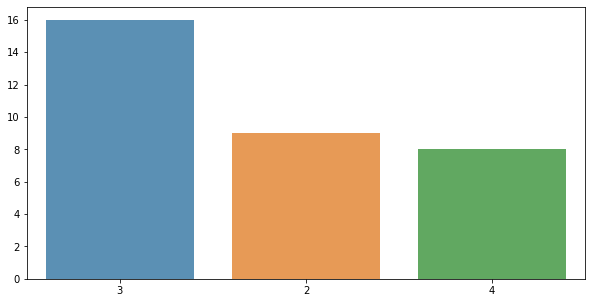

In [33]:
Period_Count =\
df_buy_price.period.value_counts(sort=True).nlargest(3)
plt.figure(figsize=(10,5))
sns.barplot(Period_Count.index,
Period_Count.values, alpha=0.8)
plt.show()

In [34]:
df9 = df_buy_price[df_buy_price['period'] != '2'].copy()
df9['div_rnk'] = df9.mkt_pct.rank(ascending=False)
df9['amt_rnk'] = df9.amount.rank(ascending=False)
df9_out = df9[colt].sort_values('div_rnk')
df9_tab = pn.widgets.Tabulator(df9_out, layout='fit_data', width=900)
df9_tab

Tabulator(layout='fit_data', value=      name  shares  ..., width=900)

In [35]:
df_buy_price.loc[short_term].head().style.format(format_dict)

,name,shares,unit_cost,cost,dividend,div_amt,cost_pct,price,amount,mkt_pct,profit,pft_pct,period
9,WHART,"10,000",12.50,"125,000.00",0.83,"8,298.00",6.60%,12.20,"122,000.00",6.80%,"-3,000.00",-2.40%,4
11,TOP,"3,000",50.00,"150,000.00",1.30,"3,900.00",2.60%,52.25,"156,750.00",2.50%,"6,750.00",4.50%,4
20,TU,"18,000",20.80,"374,400.00",0.85,"15,300.00",4.10%,20.50,"369,000.00",4.10%,"-5,400.00",-1.40%,4
23,NER,"36,000",7.45,"268,200.00",0.22,"7,920.00",3.00%,7.00,"252,000.00",3.10%,"-16,200.00",-6.00%,4
26,KBANK,"2,400",136.50,"327,600.00",3.00,"7,200.00",2.20%,142.50,"342,000.00",2.10%,"14,400.00",4.40%,4


In [36]:
data = df_buy_price.loc[short_term]
names = data['name']
in_p = ", ".join(map(lambda name: "'%s'" % name, names))
in_p

"'WHART', 'TOP', 'TU', 'NER', 'KBANK', 'BGRIM', 'SCC', 'RJH'"

In [37]:
sql = '''
SELECT name, min_price AS min, price, max_price AS max
FROM stocks
WHERE name IN (%s)'''
sql = sql % in_p
print(sql)

stocks = pd.read_sql(sql, conmy)
stocks.set_index('name',inplace=True)
stocks


SELECT name, min_price AS min, price, max_price AS max
FROM stocks
WHERE name IN ('WHART', 'TOP', 'TU', 'NER', 'KBANK', 'BGRIM', 'SCC', 'RJH')


,min,price,max
name,,,
BGRIM,38.25,39.25,56.00
KBANK,101.00,142.50,153.00
NER,4.18,7.00,8.65
RJH,23.90,33.25,39.00
SCC,364.00,380.00,474.00
TOP,42.50,52.25,66.00
TU,13.40,20.50,23.00
WHART,10.68,12.20,14.08


In [38]:
stocks.drop('SCC',inplace=True)
stocks

,min,price,max
name,,,
BGRIM,38.25,39.25,56.00
KBANK,101.00,142.50,153.00
NER,4.18,7.00,8.65
RJH,23.90,33.25,39.00
TOP,42.50,52.25,66.00
TU,13.40,20.50,23.00
WHART,10.68,12.20,14.08


<AxesSubplot:xlabel='name'>

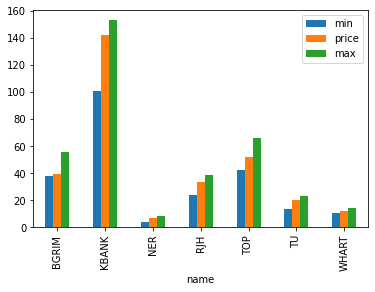

In [39]:
stocks.plot.bar()

In [40]:
#stocks.reset_index('name',inplace=True)
#sns.barplot(x='name', y='price', data=stocks)